# ERA5 datasets

See also 

[Official ERA5 data documentation from ECMWF](https://confluence.ecmwf.int/display/CKB/ERA5+data+documentation)

[Access through Copernicus Climiate Service](https://climate.copernicus.eu/climate-reanalysis?q=products/climate-reanalysis)

ERA5 hourly data (0.25 deg x 0.25 deg resolution) available with a few (~4) days latency

New ERA5-land hourly data (0.1 deg x 0.1 deg resolution) available with a few months latency



# ERA5 in AWS PDS (updated monthly however only up to end of 2019 as of March 2020)

https://github.com/planet-os/notebooks/blob/master/aws/era5-pds.md

In [3]:
# Initialize notebook environment.
%matplotlib inline
import boto3
import botocore
import datetime
import matplotlib.pyplot as plt
import os.path
import xarray as xr

In [4]:
# Connect to the bucket
era5_bucket = 'era5-pds'
# No AWS keys required
client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED))

In [5]:
# List available folders
paginator = client.get_paginator('list_objects')
result = paginator.paginate(Bucket=era5_bucket, Delimiter='/')
for prefix in result.search('CommonPrefixes'):
    print(prefix.get('Prefix'))

1979/
1980/
1981/
1982/
1983/
1984/
1985/
1986/
1987/
1988/
1989/
1990/
1991/
1992/
1993/
1994/
1995/
1996/
1997/
1998/
1999/
2000/
2001/
2002/
2003/
2004/
2005/
2006/
2007/
2008/
2009/
2010/
2011/
2012/
2013/
2014/
2015/
2016/
2017/
2018/
2019/
QA/
cds/
zarr/


In [6]:
# Search available data for specified month
keys = []
date = datetime.date(2019,12,1) # update to desired date
prefix = date.strftime('%Y/%m/')

response = client.list_objects_v2(Bucket=era5_bucket, Prefix=prefix)
response_meta = response.get('ResponseMetadata')

if response_meta.get('HTTPStatusCode') == 200:
    contents = response.get('Contents')
    if contents == None:
        print("No objects are available for %s" % date.strftime('%B, %Y'))
    else:
        for obj in contents:
            keys.append(obj.get('Key'))
        print("There are %s objects available for %s\n--" % (len(keys), date.strftime('%B, %Y')))
        for k in keys:
            print(k)
else:
    print("There was an error with your request.")

There are 19 objects available for December, 2019
--
2019/12/data/air_pressure_at_mean_sea_level.nc
2019/12/data/air_temperature_at_2_metres.nc
2019/12/data/air_temperature_at_2_metres_1hour_Maximum.nc
2019/12/data/air_temperature_at_2_metres_1hour_Minimum.nc
2019/12/data/dew_point_temperature_at_2_metres.nc
2019/12/data/eastward_wind_at_100_metres.nc
2019/12/data/eastward_wind_at_10_metres.nc
2019/12/data/integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation.nc
2019/12/data/lwe_thickness_of_surface_snow_amount.nc
2019/12/data/northward_wind_at_100_metres.nc
2019/12/data/northward_wind_at_10_metres.nc
2019/12/data/precipitation_amount_1hour_Accumulation.nc
2019/12/data/sea_surface_temperature.nc
2019/12/data/sea_surface_wave_from_direction.nc
2019/12/data/sea_surface_wave_mean_period.nc
2019/12/data/significant_height_of_wind_and_swell_waves.nc
2019/12/data/snow_density.nc
2019/12/data/surface_air_pressure.nc
2019/12/main.nc


In [7]:
# select date and variable of interest
date = datetime.date(2019,12,1)
var = 'precipitation_amount_1hour_Accumulation'

# file path patterns for remote S3 objects and corresponding local file
s3_data_ptrn = '{year}/{month}/data/{var}.nc'
data_file_ptrn = '{year}{month}_{var}.nc'

year = date.strftime('%Y')
month = date.strftime('%m')
s3_data_key = s3_data_ptrn.format(year=year, month=month, var=var)
data_file = data_file_ptrn.format(year=year, month=month, var=var)

if not os.path.isfile(data_file): # check if file already exists
    print("Downloading %s from S3..." % s3_data_key)
    client.download_file(era5_bucket, s3_data_key, data_file)

ds = xr.open_dataset(data_file)
ds.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:                                  (lat: 721, lon: 1440, nv: 2, time1: 744)
Coordinates:
  * lon                                      (lon) float32 0.0 0.25 ... 359.75
  * lat                                      (lat) float32 90.0 89.75 ... -90.0
  * time1                                    (time1) datetime64[ns] 2019-12-01 ... 2019-12-31T23:00:00
Dimensions without coordinates: nv
Data variables:
    time1_bounds                             (time1, nv) datetime64[ns] ...
    precipitation_amount_1hour_Accumulation  (time1, lat, lon) float32 ...
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    title:        ERA5 forecasts>

In [8]:
locs = [
    {'name': 'cape_town', 'lon': 18.423300, 'lat': -33.918861},
    {'name': 'dubai', 'lon': 55.316666, 'lat': 25.266666},
]

# convert westward longitudes to degrees east
for l in locs:
    if l['lon'] < 0:
        l['lon'] = 360 + l['lon']
locs

[{'name': 'cape_town', 'lon': 18.4233, 'lat': -33.918861},
 {'name': 'dubai', 'lon': 55.316666, 'lat': 25.266666}]

In [9]:
ds_locs = xr.Dataset()

# interate through the locations and create a dataset
# containing the temperature values for each location
for l in locs:
    name = l['name']
    lon = l['lon']
    lat = l['lat']
    var_name = name

    ds2 = ds.sel(lon=lon, lat=lat, method='nearest')

    lon_attr = '%s_lon' % name
    lat_attr = '%s_lat' % name

    ds2.attrs[lon_attr] = ds2.lon.values.tolist()
    ds2.attrs[lat_attr] = ds2.lat.values.tolist()
    ds2 = ds2.rename({var : var_name}).drop(('lat', 'lon'))
    
    ds_locs = xr.merge([ds_locs, ds2])

ds_locs.data_vars

Data variables:
    time1_bounds  (time1, nv) datetime64[ns] 2019-11-30T21:00:00 ... 2019-12-31T23:00:00
    cape_town     (time1) float32 ...
    dubai         (time1) float32 ...

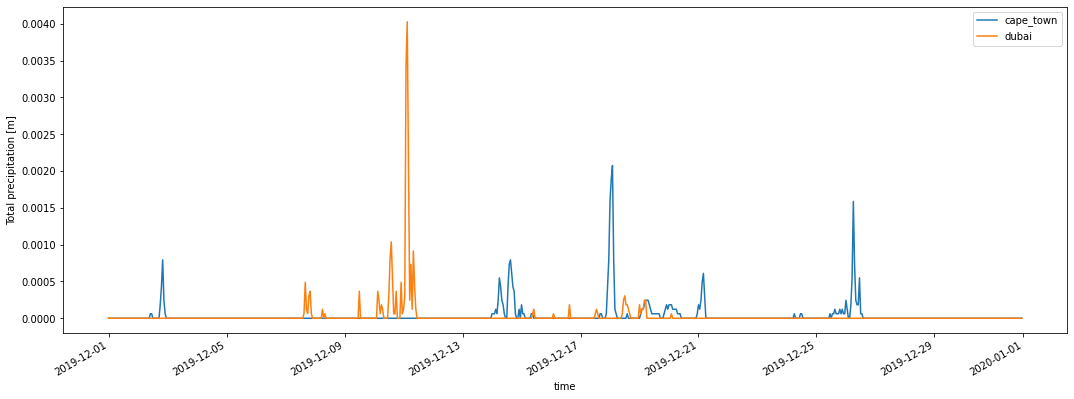

In [19]:
fig = plt.figure(figsize=(18,6))
for var in [loc['name'] for loc in locs]:
    ds_locs[var].plot(label=var)
plt.legend()